<a href="https://colab.research.google.com/github/FlyingWorkshop/DiffusionGNNTutorial/blob/main/toy_gnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task: implement a GNN to predict one (invariant) molecular feature (e.g. molecular weight) of the molecules in the QM9 data set

In [1]:
!pip install torch_geometric
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 59.3 MB/s eta 0:00:00


In [3]:
# load QM9 dataset
# documentation: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html?highlight=qm9#torch_geometric.datasets.QM9

from torch_geometric.datasets import QM9

# TODO: figure out how to not download this from scratch each time
dataset = QM9(root='./data/QM9/')

Extracting data/QM9/raw/qm9.zip
Processing...
100%|██████████| 133885/133885 [02:18<00:00, 969.06it/s] 
Done!


In [6]:
# explore what one example looks like

example = dataset[7]
print(f"{example['name']=}")
print(f"{example.num_node_features=}")
print(f"{example.x.shape=}") # the shape of x is (??, num_node_features)
print(f"{example.y.shape=}")
example.__dict__

example['name']='gdb_8'
example.num_node_features=11
example.x.shape=torch.Size([6, 11])
example.y.shape=torch.Size([1, 19])


{'_edge_attr_cls': torch_geometric.data.data.DataEdgeAttr,
 '_tensor_attr_cls': torch_geometric.data.data.DataTensorAttr,
 '_store': {'x': tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 3.],
         [0., 0., 0., 1., 0., 8., 0., 0., 0., 0., 1.],
         [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]), 'edge_index': tensor([[0, 0, 0, 0, 1, 1, 2, 3, 4, 5],
         [1, 2, 3, 4, 0, 5, 0, 0, 0, 1]]), 'edge_attr': tensor([[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]]), 'y': tensor([[ 1.5258e+00,  1.6970e+01, -7.2192e+00,  2.1334e+00,  9.3526e+00,
           8.3794e+01,  1.3934e+00, -3.1478e+03, -3.1477e+03, -3.1477e

In [7]:
# let's predict e_homo (energy of the highest occupied molecular orbital), but first let's extract the e_homo target from our example

target_idx = 2
example.y[:, target_idx]

tensor([-7.2192])

In [8]:
# Now that we've identified what target feature we're gonna try to predict, let's examine the dataset as a whole so we can prepare to batch it

print(f"{len(dataset)=}")

len(dataset)=130831


In [4]:
# create a GCN w/ PyG
# GCNConv documentation: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = torch.mean(x)

        return x

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

progress_interval = 1000
history = []

In [14]:
history = []
interval_loss = 0
model.train()
for i, ex in enumerate(dataset):
  ex.to(device)
  optimizer.zero_grad()
  out = model(ex)
  target = ex.y[:, target_idx][0]
  loss = F.mse_loss(out, target)
  loss.backward()
  optimizer.step()
  interval_loss += loss
  if i % progress_interval == 0:
    interval_loss = torch.mean(interval_loss)
    print(f"{i}: {interval_loss.detach().item()}")
    history.append(interval_loss)
    interval_loss = 0

0: 155.9081268310547
1000: 1919.3687744140625
2000: 749.4392700195312
3000: 579.6038208007812
4000: 551.2953491210938
5000: 387.7484130859375
6000: 392.8779296875
7000: 253.24449157714844
8000: 248.2297821044922
9000: 281.3978271484375
10000: 220.33372497558594
11000: 206.29107666015625
12000: 167.37429809570312
13000: 147.98390197753906
14000: 165.56829833984375
15000: 166.5443878173828
16000: 154.9215087890625
17000: 155.74156188964844
18000: 165.38563537597656
19000: 184.5306854248047
20000: 155.7921142578125
21000: 446.1719055175781
22000: 447.6114196777344
23000: 241.64541625976562
24000: 405.6269226074219
25000: 480.2321472167969
26000: 354.6628112792969
27000: 406.5538635253906
28000: 385.2294006347656
29000: 406.4471130371094
30000: 368.4708251953125
31000: 445.06939697265625
32000: 403.6418151855469
33000: 374.6795959472656
34000: 199.38172912597656
35000: 200.796875
36000: 217.29165649414062
37000: 163.4990234375
38000: 125.77611541748047
39000: 124.80870056152344
40000: 131.

Text(0.5, 0, 'Examples')

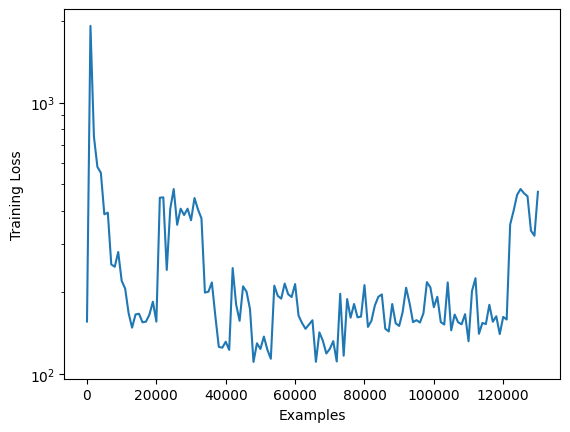

In [24]:
import matplotlib.pyplot as plt
import numpy as np

if not isinstance(history[0], np.ndarray):
  # move interval loss tensors to CPU if not already
  history = [elem.cpu().detach().numpy() for elem in history]
x = np.arange(0, progress_interval * len(history), progress_interval)
plt.plot(x, history)
plt.yscale('log')
plt.ylabel("Training Loss")
plt.xlabel("Examples")